# Abstract
paragraph describing the motivation for your paper and a high-level overview of your approach and results.



Every year (including once last week), highly endangered right whales are killed from human marine activity. To try to prevent this, some have proposed placing buoys in high traffic areas which listen for whales and automatically alert nearby vessels. For this to be feasible we must have accurate machine learning models that quickly identify whale sounds: the goal of this project. 

This project takes a dataset of 30,00 labeled two second hydrophone recoding’s from a Kaggle competition and runs three different ML models to try to identify if a whale was present in the recording.

All three techniques had reasonable performance, and both CNN models had greater than 90% performance, however the most complex CNN architecture stood out as have significantly lower false negative error rate, which is the most harmful form of error for this problem.

# Introduction
Explain the problem you’re investigating and why it’s interesting and/or important. Introduce your basic approach and the input and intended output for your approach. E.g., “We aim to predict music genre based on 3 second clips of the beginning of songs using a neural network.”

![News story about death taking place during final project](./src/news_story.png)

# Related Work
Either as part of the introduction or in a separate section, give a brief overview of how others have solved this problem. You don’t need to do a complete literature search, but you should briefly summarize the approach and results of any other work that you found that is tackling this or a similar problem.

# Dataset

## Goal

Describe your dataset, including how many training, validation, and test samples you have (or if you’re using cross-validation rather than a separate validation set). Describe any preprocessing and/or data normalization that you performed, as well as any data augmentation. Describe the types of features you used, including anything that was present in the data versus that you added (e.g., adding features that are the interactions of other features). For images or other complex data, make sure to describe any relevant characteristics like resolution or length for audio/text. Cite where you obtained the data (or how you collected it if you collected it yourself). For classification problems, make sure to indicate the number of classes. If you have space, including some examples of your data may be helpful.

## About Source Data

Sourced from [The Marinexplore and Cornell University Whale Detection Challenge on Kaggle](https://www.kaggle.com/competitions/whale-detection-challenge), 
my dataset contained 30,000 two second audio files and an accopanied csv file with the labels. The audio files were all aiff sound clip with a sample rate of 2 kHz. The csv file contained the file name and the label. The label was a 1 if a whale was present in the audio file and a 0 if a whale was not present.

## Pre-processing

To take advantage of my in class learning, my first goal was to turn this audio catagorization problem into an image catagorization problem. I used LibRosa to convert the audio files into spectrograms. I then used the spectrograms as the input to my models. 

To see how I bulk converted the audio files into spectrograms, see my [github](https://github.com/levshuster/whale-detection), but here is an example of creating a single spectrogram from a single audio file.

This code is loosly based on [Transforming 2kHz .aiff Whale audio to .png](https://www.kaggle.com/code/diegoasuarezg/transforming-2khz-aiff-whale-audio-to-png) by Diego Suarez

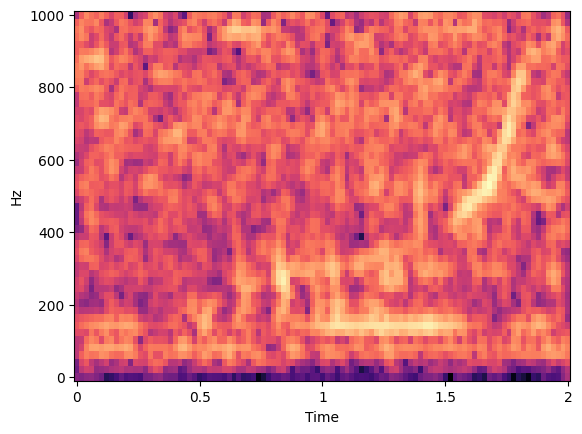

In [5]:
import librosa
import soundfile as sf
import numpy as np


audio_data, sample_rate = sf.read('./src/train1.aiff')
hl = 40

librosa.display.specshow(
	librosa.power_to_db(
		librosa.feature.melspectrogram(
			y=audio_data,
			sr=sample_rate,
			n_fft=200,
			hop_length=hl,
			n_mels=50,
			fmax=500
		), 
		ref=np.max
	),
	x_axis='time',
	y_axis='linear',
	sr=sample_rate,
	hop_length=hl, 
)

The audio to image pre-processing step makes a few critical decisions including the max frequency and the resolution. Both decsions made to align with previous work on the same dataset.

![Example whale images](./src/example_whale_images.png)


I also re-processed the data to match Kerass's folder input structure. Because the orignal set of images are too large to include in this kip, to see all the code that I used to pre-process the data, see my [github](https://github.com/levshuster/whale-detection). The result are a colleciton of folders labeled by their training/testing split and number of images in each folder. See the `dataset` folder for an example. Lastly, I converted all the training images into one large numpy array and all the testing images into another large numpy array. Again, this work can be found on my git hub.



## Training, Validation and Testing

I used a 80/20 split for training and testing. I then used a 80/20 split for training and validation. To create a subset of the 30,000 I randomly pulled images from the total set.

# Methods
Describe your learning algorithms, including all variations. Please use relevant mathematical notation, and include a short description about how each algorithm works. You can assume your reader is an intelligent computer scientist who knows the big idea behind a machine learning problem (e.g., you don’t have to describe why you’re using a separate test test or why the gradient is used for optimization), but who doesn’t know your specific algorithm. Your goal is to demonstrate your understanding of the algorithm(s) and clearly communicate that to the reader, who might be me or might be another classmate as I will ask you to post your paper on Moodle for your classmates to view.


## K-Nearest Neighbors

### How it works

### Variations

In [16]:
import pickle
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


class KNN:
	last_fit_hash = None
	last_prediciton_hash = None
	last_prediction = None
	def __init__(self, n_neighbors, version, dataset_name, do_not_load=False):
		self.n_neighbors = n_neighbors
		self.version = version
		self.dataset_name = dataset_name
		self.do_not_load = do_not_load
		self.model = KNeighborsClassifier(
			n_neighbors=n_neighbors,
			n_jobs=-1,
			algorithm='kd_tree',
		)
		print(f'KNN model with {n_neighbors} neighbors created')

	def fit(self, x_train, y_train):
		x_train_hash = hash(x_train.tobytes())
		if x_train_hash == self.last_fit_hash:
			print('Last Fit Cached')
		else: 
			print(f'Fitting model with {len(x_train)} samples')
			self.last_fit_hash = x_train_hash
			self.model.fit(x_train, y_train)
		return self

	def predict(self, X):
		X_hash = hash(X.tobytes())
		if X_hash == self.last_prediciton_hash:
			print('Last Precition Cached')
		else:
			self.last_prediciton_hash = X_hash
			self.last_prediction = self.model.predict(X)
			self.save()
		return self.last_prediction
	
	def get_name(self):
		return f'./models/{self.n_neighbors}-nn_{self.version}_{self.dataset_name}.pkl'

	def save(self):
		print(f'Saving model {self.get_name()}')
		with open(self.get_name(), 'wb') as f:
			pickle.dump(self, f)
		return self
		
	def load(self):
		if self.do_not_load:
			print('Warning: do_not_load flag set to true, model will not be loaded from disk')
			return self
		try:
			with open(self.get_name(), 'rb') as f:
				print(f'Model {self.get_name()} loaded')
				return pickle.load(f)
		except:
			print(f'Warning: could not load model {self.get_name()}')
			return self

dataset_name = '5500'
dataset_name = '200'
folder = f'./dataset/numpy/{dataset_name}-training/'
# dataset_name = '100'
# folder = f'../input/numpy/100-samples/'

x_train = np.load(folder+'x_flatten.npy')
y_train = np.load(folder+'y.npy')

KNN(
	n_neighbors=1,
	version='0.3',
	dataset_name=dataset_name,
	do_not_load=False
)\
	.load()\
	.fit(x_train, y_train)\
	.save()

KNN model with 1 neighbors created
Fitting model with 400 samples
Saving model ./models/1-nn_0.3_200.pkl


In [17]:
folder = f'./dataset/numpy/{dataset_name}-testing/'
x_test = np.load(folder+'x_flatten.npy')
y_test = np.load(folder+'y.npy')

y_pred = KNN(
	n_neighbors=1,
	version='0.3',
	dataset_name=dataset_name,
	do_not_load=False
).load().predict(x_test)

# it took 40 minutes to run 2832 inputs which means 40*60/2832 ~ 1 second per a prediction --> a fast mac would struggle to keep up with a single audio recording
	

KNN model with 1 neighbors created
Model ./models/1-nn_0.3_200.pkl loaded
Saving model ./models/1-nn_0.3_200.pkl


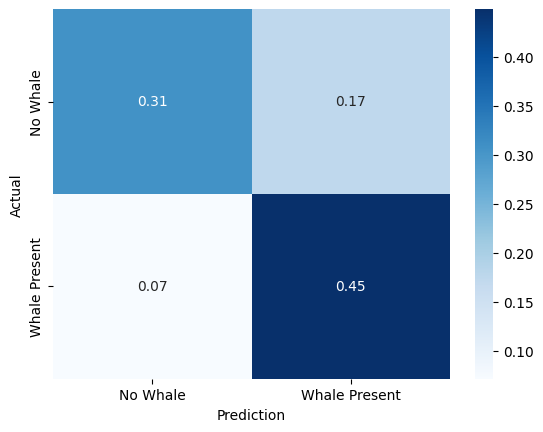

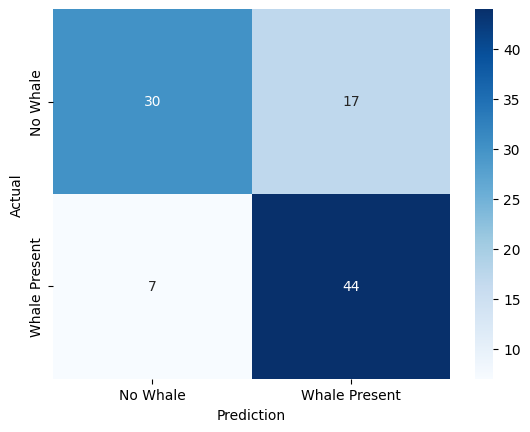

'Accuracy: 0.7551020408163265'

In [18]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot(y_true, y_pred, labels, normalize = False):
	cf_matrix = confusion_matrix(y_true, y_pred)
	sns.heatmap(
		cf_matrix if not normalize else cf_matrix/np.sum(cf_matrix), 
		annot=True,
		fmt='d' if not normalize else '.2f',
		xticklabels=labels,
		yticklabels=labels,
		cmap='Blues'
	).set(
		xlabel='Prediction',
		ylabel='Actual'
	)
	plt.show()

labels = ['No Whale','Whale Present']
confusion_matrix_plot(y_test, y_pred, labels, normalize = True)
confusion_matrix_plot(y_test, y_pred, labels, normalize = False)

def get_accuracy(y_test, y_pred):
	return np.sum(y_test == y_pred) / len(y_test)
f"Accuracy: {get_accuracy(y_test, y_pred)}"

## ResNet


### How it works

### Variations

## Simple Convolutional Neural Network


### How it works

### Variations

# Experiments and results
Describe the experiments that you ran, including specifics about what you were testing and why. For example, you might note that you considered feature sets X, Y, and Z, where you thought Y would lead to highest performance due to not enough information in X and likely overfitting in Z. Explain how you chose X, Y, and Z. For any hyperparameters, such as learning rate or batch size for stochastic gradient descent, describe how you chose the values you used. Describe your metrics for evaluating performance, such as accuracy, precision, recall, accuracy for a particular subgroup, etc. Make sure that your experiments and metrics are described in sufficient detail that they could be replicated by someone else. Describe your results and your interpretation for them (e.g., if Z outperforms both X and Y, what does that mean and why might that have occurred?). You should present your results in graphs and/or tables that clearly communicate the key findings to your reader; these graphs/tables should be clearly labeled, including legends and axis labels, and the font should be big enough to be legible on the screen without resizing. In your results, you’ll likely want to perform some error analysis, examining what kinds of errors your model makes.


## K-Nearest Neighbors

## ResNet

## Simple Convolutional Neural Network

# Discussion and future work
Briefly summarize your project and results, emphasizing the key findings and takeaways. Discuss any overarching themes about what performed best and why, and/or what you learned from the project. If you had additional time or resources, what next steps would you want to explore, and what new questions have been raised by your investigation? Are there any particular impacts that your project (or solution to the problem you’re investigating) could have on society, and are there any ethical concerns that are brought up by your problem, approach, or results?